In [1]:
pip install tensorflow

In [2]:
import kagglehub
import os
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D,MaxPooling2D, Flatten, Dense, Input, Dropout)
from keras.applications import EfficientNetB0
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.applications import InceptionV3
from keras.applications import MobileNetV3Large
from keras.layers import GlobalAveragePooling2D
from keras.models import Model
from tensorflow.keras import layers, models
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from keras.regularizers import l2
from keras.utils import to_categorical

In [3]:
def plot_history(history):
  """
  Funkce na vykreslení dat z objectu history -> vrací ho metoda fit keras modelu
  """
  # plot the Loss curve(s)
  plt.figure(figsize=[8,6])

  plt.plot(history.history['loss'],'r',linewidth=3.0)
  plt.plot(history.history['val_loss'],'b',linewidth=3.0)

  plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
  plt.xlabel('Epochs ',fontsize=16)
  plt.ylabel('Loss',fontsize=16)
  plt.title('Loss Curves',fontsize=16)
  plt.show()

  # plot the Accuracy curve(s)
  plt.figure(figsize=[8,6])

  plt.plot(history.history['accuracy'], 'r', linewidth=3.0)
  plt.plot(history.history['val_accuracy'], 'b',linewidth=3.0)

  plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
  plt.xlabel('Epochs ',fontsize=16)
  plt.ylabel('Accuracy',fontsize=16)
  plt.title('Accuracy Curves',fontsize=16)
  plt.show()

## Načtení a preprocessing dat

In [4]:
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/MyDrive/FinalProject/'
#%cd path
%cd /content/drive/MyDrive/FinalProject/
fotky_emoce = os.listdir(f"{path}/train_OK")

Mounted at /content/drive
/content/drive/MyDrive/FinalProject


In [5]:
# Načtení fotek a přiřazení názvů emocí ( labling)
X = []
y = []
encoding = {}

for index, emoce in enumerate(fotky_emoce):
  encoding[index] = emoce
  folder_path = os.path.join(f"{path}/train_OK", emoce)

  # Vytvoření datasetu
  image_list = []
  for filename in os.listdir(folder_path):
    if filename.endswith(".jpg"):
        img_path = os.path.join(folder_path, filename)
        img = Image.open(img_path)
        img_resized = img.resize((48, 48))   # změna velikosto obrázku
        img_array = np.array(img_resized)    # převod na numpy array
        image_list.append(img_array)         # rozšíření seznamu obrázků

  X += image_list    #   Přidáme všechny obrázky z této složky do seznamu X.
  y += [index] * len(image_list)  ## přiřazení čísel k labelům

In [6]:
X = np.stack(X)
y = np.array(y)
X = X / 255  # Normalizování obrázků

In [7]:
# rozdělení, trénink test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)
# one hot encoding y
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [8]:
# Zastavení trénování modelu, pokud nejsou změny větší než 0,3%
early = EarlyStopping(
    monitor="val_accuracy",
    min_delta=0.003,
    patience=10,
    restore_best_weights=True,
)
# Uložení nejlepšího modelu
save = ModelCheckpoint(
    filepath=f"{path}/best_models/best_model_nase_neuronova_sit.keras",
    monitor="val_accuracy",
    save_best_only=True,
    save_weights_only=False,
    save_freq="epoch"
)

## Trénování modelu našeho modelu neuronové sítě

In [9]:
model = Sequential()
model.add(Input(shape=(48, 48, 1)))
# První konulenční vrstva neuronové sitě
model.add(Conv2D(32, (3, 3),input_shape=(48, 48, 1)))
model.add(MaxPooling2D())
# Druhá konulenční vrstva neuronové sitě
model.add(Conv2D(32, (3, 3)))
model.add(MaxPooling2D())
# Třetí konulenční vrstva neuronové sitě
model.add(Conv2D(64, (3, 3)))
model.add(MaxPooling2D())

model.add(Flatten())   # převod na vektor
model.add(Dropout(0.5))  # regularizace proti overfittingu

# Klasifikační vrstva
model.add(Dense(128, activation='relu'))   ## kernel_regularizer=l2(0.001)

# výstupní vrstva -> multiclass single label -> softmax
model.add(Dense(len(fotky_emoce), activation="softmax"))

# kompilace
model.compile(loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 46, 46, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 23, 23, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 21, 21, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 10, 10, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 8, 8, 64)            │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 4, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 160,167 (625.65 KB)

 Trainable params: 160,167 (625.65 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
## Total params:   Celkový počet parametrů ve vašem modelu, které jsou trénovatelné i netrénovatelné dohromady.
## Trainable params:  Počet parametrů, které se mění během trénování – model se učí jejich optimální hodnoty.

In [10]:
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), batch_size=32, callbacks=[early, save])

Epoch 1/100
283/283 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - accuracy: 0.3842 - loss: 1.6504 - val_accuracy: 0.5323 - val_loss: 1.3251
Epoch 2/100
283/283 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5707 - loss: 1.2140 - val_accuracy: 0.6238 - val_loss: 1.0527
Epoch 3/100
283/283 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6257 - loss: 1.0597 - val_accuracy: 0.6353 - val_loss: 1.0156
Epoch 4/100
283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6476 - loss: 0.9955 - val_accuracy: 0.6636 - val_loss: 0.9138
Epoch 5/100
283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6846 - loss: 0.8890 - val_accuracy: 0.6844 - val_loss: 0.8729
Epoch 6/100
283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7056 - loss: 0.8063 - val_accuracy: 0.6967 - val_loss: 0.8365
Epoch 7/100
283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7203 - loss: 0.7734 - val_accuracy: 0.7131 - val_loss: 0.8153
Epoch 8/100
283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7375 - loss: 0.7274 - val_acc

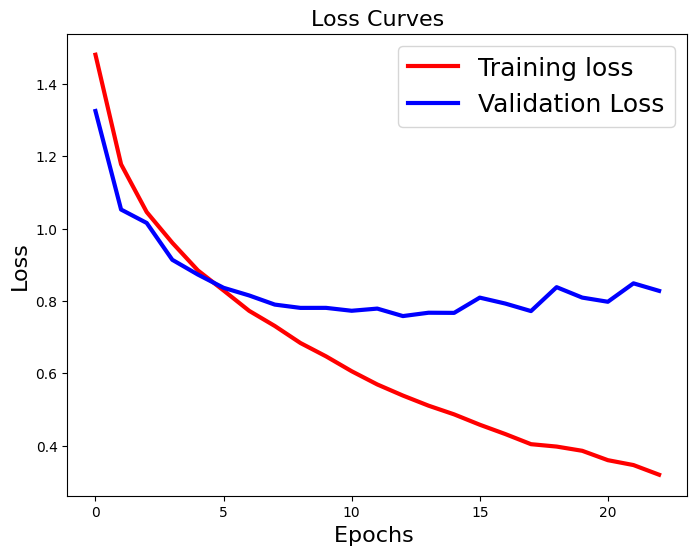

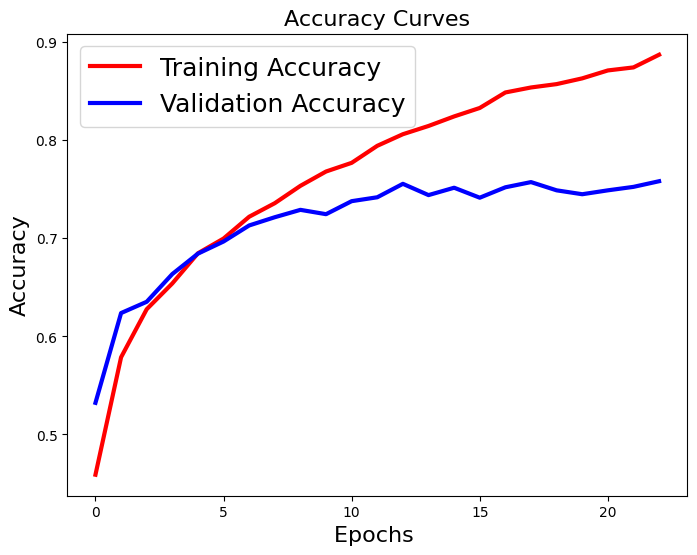

In [11]:
plot_history(history)

In [12]:
model = load_model(f"{path}/best_models/best_model_nase_neuronova_sit.keras")

In [13]:
y_pred = model.predict(X_test)

71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


In [14]:
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(y_test, axis=1)

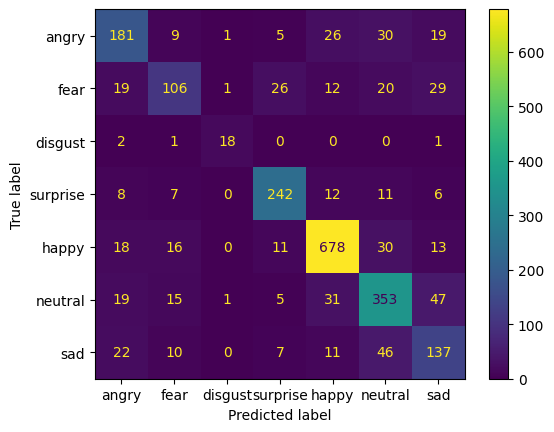

In [15]:
class_labels = list(encoding.values())
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot()